## Necessary Imports and Paths

In [1]:
!pip install seaborn
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
import warnings

import multiprocessing as mp
import os

warnings. filterwarnings('ignore')

def  color_print(print_str,
                 print_color='green'):

    '''print in given  color (default green)'''
    print(colored(print_str,print_color))

In [ ]:
import tensorflow as tf

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [4]:
gt_path = '/kaggle/input/soil-hyperspectral-images/train_data/train_data/train_gt.csv'
wavelength_path = '/kaggle/input/soil-hyperspectral-images/train_data/train_data/wavelengths.csv'

In [5]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

In [6]:
classes = ['P','K','Mg','pH']

## Function to Load .npz file and mask it

With masking, some of the pixels are made 0 to keep the relevant portions of the image.
With padding, the shape of the same image, remains the same by converting irrelevant portions to 0

In [7]:
def load_npz_file(filepath, masked, pad_mask):
    with np.load(filepath) as npz:
      arr = np.ma.MaskedArray(**npz)

    if masked == True:
      if pad_mask : # pad masked pixels with 0's to preserve shape
        mask = arr.mask
        return np.where(mask==True,0,arr.data)

    return arr

## Function to Reshape Images into height*width rows, depth columns format, as well as add target variables

In [8]:
def load_and_reshape(filepath):
    '''load and reshape array'''

    arr = load_npz_file(filepath,
                        masked=False,
                        pad_mask=False)

    index = filepath.split('/')[-1].split(sep='.')[0]

    depth,height,width = arr.shape
    arr = arr.reshape((height*width,depth))

    for i in classes:
      i_value = gt_df.loc[gt_df['sample_index']==int(index)][i].iloc[0]
      duplicated_array = np.full((height*width, 1), i_value)

      arr = np.concatenate((arr, duplicated_array), axis=1)
    
    ## To keep which values belong to which image
    duplicated_array = np.full((height*width, 1), index)
    arr = np.concatenate((arr, duplicated_array), axis=1)
    
    return arr

In [9]:
# hyperspectral image tiles
train_tiles_folder = '/kaggle/input/soil-hyperspectral-images/train_data/train_data/train_data'

In [10]:
#adding paths to train_gt csv
gt_df['paths'] = train_tiles_folder + '/' +gt_df['sample_index'].astype(str) + '.npz'

#check if all the paths exists

all([os.path.exists(path) for path in gt_df['paths']])

True

In [11]:
load_and_reshape(gt_df['paths'][0]).shape

(121, 155)

In [12]:
gt_df.head()

,sample_index,P,K,Mg,pH,paths
0,0,45.1,188.0,179.0,7.2,/kaggle/input/soil-hyperspectral-images/train_...
1,1,44.8,205.0,188.0,7.0,/kaggle/input/soil-hyperspectral-images/train_...
2,2,44.4,207.0,145.0,6.8,/kaggle/input/soil-hyperspectral-images/train_...
3,3,46.5,204.0,143.0,6.8,/kaggle/input/soil-hyperspectral-images/train_...
4,4,52.0,212.0,167.0,6.7,/kaggle/input/soil-hyperspectral-images/train_...


In [ ]:
load_and_reshape(gt_df['paths'][0]).shape

In [ ]:
load_and_reshape(gt_df['paths'][1725]).shape

In [ ]:
load_and_reshape(gt_df['paths'][1731]).shape

## Visualize masked images

Shape of the selected sample image (150, 142, 155) (channels, height,width)


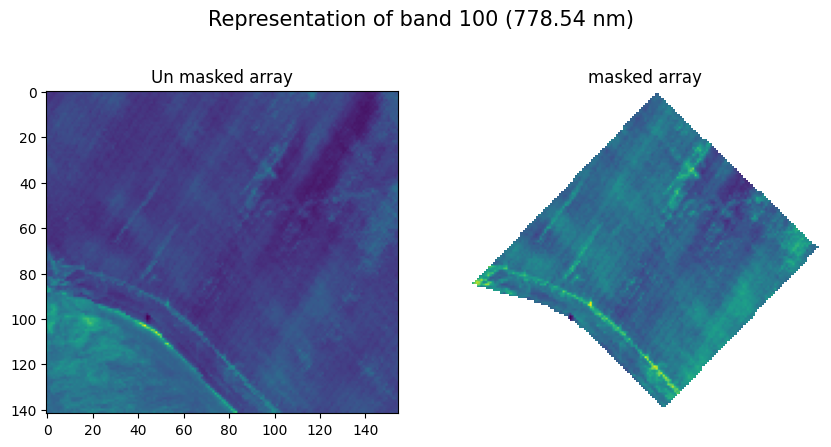

In [15]:
# display a single band

#choose a sample
rand_sample_path = gt_df.sample(n=1)['paths'].values[0]


arr = load_npz_file(rand_sample_path, masked=False, pad_mask=False)


color_print(f'Shape of the selected sample image {arr.shape} (channels, height,width)')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelen = wavelength_df.loc[band_id-1]


axs[0].imshow(arr[band_id,:,:].data)
plt.axis('off')
axs[0].set_title('Un masked array')

axs[1].imshow(arr[band_id,:,:])
plt.axis('off')
axs[1].set_title('masked array')


plt.suptitle(f'Representation of band {int(wavelen["band_no"])} ({wavelen["wavelength"]} nm)', fontsize=15)
plt.show()

## Prepare final df using multiprocessing

In [16]:
Final_df = pd.DataFrame()

In [17]:
def process_path(path):
    arr = load_and_reshape(path)
    df = pd.DataFrame(arr)
    return df

# List of file paths
file_paths = gt_df.paths.values  # Assuming gt_df is a DataFrame containing paths

# Number of processes to use
num_processes = os.cpu_count()  # Use all available CPU cores

# Use multiprocessing Pool to parallelize the loading and reshaping
with mp.Pool(num_processes) as pool:
    result_dfs = pool.map(process_path, file_paths)

# Concatenate the resulting DataFrames
Final_df = pd.concat(result_dfs, ignore_index=True)

pool.close()

In [18]:
Final_df.shape

(9783364, 155)

In [19]:
Final_df.rename(columns={150: 'P', 151: 'K', 152: 'Mg', 153: 'pH', 154: 'img'}, inplace=True)

In [ ]:
# Final_df.to_csv('/kaggle/working/Final.csv')

In [ ]:
# # Download the CSV file
# from IPython.display import FileLink
# FileLink('Final.csv')

In [20]:
Final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,P,K,Mg,pH,img
0,487.0,471.0,460.0,489.0,493.0,464.0,466.0,459.0,447.0,440.0,...,495.0,479.0,460.0,458.0,455.0,45.1,188.0,179.0,7.2,0
1,430.0,471.0,472.0,450.0,434.0,461.0,485.0,475.0,453.0,473.0,...,458.0,434.0,436.0,442.0,445.0,45.1,188.0,179.0,7.2,0
2,444.0,476.0,429.0,433.0,460.0,460.0,457.0,435.0,457.0,438.0,...,432.0,437.0,446.0,430.0,422.0,45.1,188.0,179.0,7.2,0
3,447.0,437.0,448.0,440.0,444.0,432.0,449.0,450.0,436.0,420.0,...,441.0,439.0,443.0,450.0,470.0,45.1,188.0,179.0,7.2,0
4,480.0,419.0,439.0,452.0,443.0,513.0,505.0,496.0,542.0,540.0,...,507.0,517.0,530.0,524.0,500.0,45.1,188.0,179.0,7.2,0


In [ ]:
# import pandas as pd
# Final_df = pd.read_csv('/kaggle/working/Final.csv')

## Split Target Variables and Features

In [21]:
y = Final_df[['pH', 'P', 'K', 'Mg']].apply(pd.to_numeric)
img_index = Final_df['img']
X = Final_df.drop(['pH', 'P', 'K', 'Mg', 'img'], axis=1)
X  = X.apply(pd.to_numeric)

In [22]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,487.0,471.0,460.0,489.0,493.0,464.0,466.0,459.0,447.0,440.0,...,457.0,467.0,467.0,484.0,454.0,495.0,479.0,460.0,458.0,455.0
1,430.0,471.0,472.0,450.0,434.0,461.0,485.0,475.0,453.0,473.0,...,449.0,444.0,435.0,465.0,487.0,458.0,434.0,436.0,442.0,445.0
2,444.0,476.0,429.0,433.0,460.0,460.0,457.0,435.0,457.0,438.0,...,445.0,441.0,446.0,459.0,426.0,432.0,437.0,446.0,430.0,422.0
3,447.0,437.0,448.0,440.0,444.0,432.0,449.0,450.0,436.0,420.0,...,446.0,418.0,475.0,458.0,462.0,441.0,439.0,443.0,450.0,470.0
4,480.0,419.0,439.0,452.0,443.0,513.0,505.0,496.0,542.0,540.0,...,563.0,552.0,516.0,507.0,490.0,507.0,517.0,530.0,524.0,500.0


In [23]:
print(X.shape, y.shape)

(9783364, 150) (9783364, 4)


In [24]:
X.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
145    float64
146    float64
147    float64
148    float64
149    float64
Length: 150, dtype: object

In [25]:
y.dtypes

pH    float64
P     float64
K     float64
Mg    float64
dtype: object

## Train Test Split

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
print(X_train.shape, y_train.shape)

(7826691, 150) (7826691, 4)


In [28]:
print(X_test.shape, y_test.shape)

(1956673, 150) (1956673, 4)


In [ ]:
# indices = np.arange(1732)
# np.random.shuffle(indices)

# train_size = int(0.8 * 1732)
# test_size = 1732-train_size

# train_indices = indices[:train_size]
# test_indices = indices[train_size:]

# X_train = pd.concat([X[X['img'] == str(i)] for i in train_indices])
# X_test = pd.concat([X[X['img'] == str(i)] for i in test_indices])

# print(X_train.shape, X_test.shape)
    
# # Determine the number of samples for the training set based on the 80-20 ratio
# # train_size = int(0.8 * 1732)

# # # Split the shuffled indices into training and testing indices
# # train_indices = indices[:train_size]
# # test_indices = indices[train_size:]

# # # Split the data into training and testing sets based on the indices
# # X_train, X_test = X[train_indices], X[test_indices]
# # y_train, y_test = y[train_indices], y[test_indices]

In [ ]:
# def concatenate_rows(i):
#     if i in indices:
#         return X[X['img'] == str(i)]
#     else:
#         return None

# # Assuming X is your DataFrame
# indices = np.arange(1732)
# np.random.shuffle(indices)

# train_size = int(0.8 * 1732)
# test_size = 1732 - train_size

# train_indices = indices[:train_size]
# test_indices = indices[train_size:]

# # Use multiprocessing to parallelize concatenation for both training and testing sets
# with mp.Pool() as pool:
#     X_train_list = pool.map(concatenate_rows, train_indices)
#     X_test_list = pool.map(concatenate_rows, test_indices)

# # Concatenate the resulting DataFrames for the training set
# X_train = pd.concat([df for df in X_train_list if df is not None])

# # Concatenate the resulting DataFrames for the testing set
# X_test = pd.concat([df for df in X_test_list if df is not None])

# pool.close()
# print(X_train.shape, X_test.shape)

In [ ]:
# for i in range(0, 1732):
#     filtered_rows = X_train[X_train['img'] == i]
#     if not filtered_rows.empty:
#         print(filtered_rows)

## Function to print Residuals

In [29]:
def resi(y_test, y_pred):
    residuals = y_test - y_pred

    # Plot residuals
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()
    
    # Residuals vs. Fitted Values plot
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.title('Residuals vs. Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='-')  # Add horizontal line at y=0
    plt.grid(True)
    plt.show()

    # Normal Q-Q plot
    plt.figure(figsize=(10, 5))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Standardized Residuals')
    plt.grid(True)
    plt.show()

## Function to do Scaling: Mean Normalization -> [-1, 1] range

In [ ]:
def scale(X):
    for i in X.columns:
        data = X[i]
        mean_value = np.mean(data)
        max_value = np.max(data)
        min_value = np.min(data)
        data_scaled = [(x - mean_value) / (max_value - min_value) for x in data]
        X[i] = np.array(data_scaled).reshape(-1, 1)
    return X

## Function to do Scaling: Normalization -> [0, 1] range

In [30]:
def scale(X):
    for i in X.columns:
        data = X[i]
        max_value = np.max(data)
        min_value = np.min(data)
        data_scaled = [(x - min_value) / (max_value - min_value) for x in data]
        X[i] = np.array(data_scaled).reshape(-1, 1)
    return X

## Linear Regression - Without PCA

### 1. pH value

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lin_reg = LinearRegression().fit(X_train, y_train['pH'])
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

In [ ]:
r2_score( y_train['pH'], y_pred_train)

In [ ]:
r2_score( y_test['pH'], y_pred_test)

In [ ]:
resi(y_test['pH'], y_pred_test)

### 2. Phosphorous value

In [ ]:
lin_reg = LinearRegression().fit(X_train, y_train['P'])
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

In [ ]:
r2_score( y_train['P'], y_pred_train)

In [ ]:
r2_score( y_test['P'], y_pred_test)

In [ ]:
resi(y_test['P'], y_pred_test)

### 3. Potassium Value

In [ ]:
lin_reg = LinearRegression().fit(X_train, y_train['K'])
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

In [ ]:
r2_score( y_train['K'], y_pred_train)

In [ ]:
r2_score( y_test['K'], y_pred_test)

In [ ]:
resi(y_test['K'], y_pred_test)

### 4. Magnesium Value

In [ ]:
lin_reg = LinearRegression().fit(X_train, y_train['Mg'])
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

In [ ]:
r2_score( y_train['Mg'], y_pred_train)

In [ ]:
r2_score( y_test['Mg'], y_pred_test)

In [ ]:
resi(y_test['Mg'], y_pred_test)

## Scaling

In [31]:
X_train = scale(X_train)
X_test = scale(X_test)

## PCA

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.9031231  0.01905214 0.01534829 0.00661842 0.0059802  0.00486623
 0.0039329  0.00330151 0.00263836 0.00241344 0.00187341 0.00162179
 0.00155553 0.00144726 0.0013523  0.00123007 0.00119003 0.00115816
 0.00093244 0.00090347]
[1797.3846185   261.05945004  234.31361265  153.86670228  146.25989985
  131.93610487  118.61067556  108.67347055   97.14810728   92.91490426
   81.86227228   76.16658837   74.59455625   71.95157204   69.55121305
   66.33332022   65.24479704   64.36521292   57.75336733   56.84933038]


In [33]:
sum(pca.explained_variance_ratio_)

0.9805390160446136

In [34]:
X_train = pca.transform(X_train)
X_train = pd.DataFrame(X_train, columns=['PC{}'.format(i) for i in range(1, 21)])

In [35]:
pca = PCA(n_components=20)
pca.fit(X_test)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[9.04930856e-01 1.89160519e-02 1.53622007e-02 7.38046632e-03
 6.39832753e-03 4.65522474e-03 4.40783865e-03 3.45752937e-03
 2.88713362e-03 2.52640664e-03 2.23831949e-03 1.75780995e-03
 1.57448508e-03 1.50914685e-03 1.45093389e-03 1.33944925e-03
 1.28152977e-03 1.05657565e-03 7.49703099e-04 7.40758709e-04]
[1349.78058981  195.15097654  175.86612598  121.89822494  113.49813207
   96.81124522   94.20377885   83.43310739   76.24105934   71.3193058
   67.12998012   59.48965356   56.30212087   55.12152582   54.04795833
   51.93003466   50.79486722   46.12175016   38.85081494   38.61836324]


In [36]:
sum(pca.explained_variance_ratio_)

0.9846207473428196

In [37]:
X_test = pca.transform(X_test)
X_test = pd.DataFrame(X_test, columns=['PC{}'.format(i) for i in range(1, 21)])

## Function for Normality Tests

In [38]:
from scipy import stats
from sklearn.metrics import mean_squared_error

def tests(residuals, std_err):
    # Shapiro-Wilk Normality Test
    shapiro_test_statistic, shapiro_p_value = stats.shapiro(residuals/std_err)
    print("Shapiro-Wilk Test:")
    print("Test Statistic:", shapiro_test_statistic)
    print("p-value:", shapiro_p_value)
    if shapiro_p_value < 0.05:
        print("Null hypothesis (residuals are normally distributed) rejected.")
    else:
        print("Null hypothesis (residuals are normally distributed) not rejected.")

    # Anderson-Darling Normality Test
    anderson_test_statistic, anderson_critical_values, anderson_significance_levels = stats.anderson(residuals/std_err)
    print("\nAnderson-Darling Test:")
    print("Test Statistic:", anderson_test_statistic)
    print("Critical Values:", anderson_critical_values)
    if anderson_test_statistic > anderson_critical_values[2]:
        print("Null hypothesis (residuals are normally distributed) rejected.")
    else:
        print("Null hypothesis (residuals are normally distributed) not rejected.")

    # Cramer Von Mises Normality Test
    cvm = stats.cramervonmises(residuals/std_err, 'norm')
    cvm_test_statistic = cvm.statistic
    cvm_p_value = cvm.pvalue
    print("\nCramer Von Mises Test:")
    print("Test Statistic:", cvm_test_statistic)
    print("p-value:", cvm_p_value)
    if cvm_p_value < 0.05:
        print("Null hypothesis (residuals are normally distributed) rejected.")
    else:
        print("Null hypothesis (residuals are normally distributed) not rejected.")

    # Kolmogorov-Smirnov Normality Test
    ks_test_statistic, ks_p_value = stats.kstest(residuals/std_err, 'norm')
    print("\nKolmogorov-Smirnov Test:")
    print("Test Statistic:", ks_test_statistic)
    print("p-value:", ks_p_value)
    if ks_p_value < 0.05:
        print("Null hypothesis (residuals are normally distributed) rejected.")
    else:
        print("Null hypothesis (residuals are normally distributed) not rejected.")

    # Shapiro Francia Normality Test
    shapiro_francia_test_statistic, shapiro_francia_p_value = stats.shapiro(residuals/std_err)
    print("\nShapiro Francia Test:")
    print("Test Statistic:", shapiro_francia_test_statistic)
    print("p-value:", shapiro_francia_p_value)
    if shapiro_francia_p_value < 0.05:
        print("Null hypothesis (residuals are normally distributed) rejected.")
    else:
        print("Null hypothesis (residuals are normally distributed) not rejected.")
    

## Linear Regression - With PCA and Scaling

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def linear_reg(i):
    lin_reg = LinearRegression().fit(X_train, y_train[i])
    y_pred_train = lin_reg.predict(X_train)
    y_pred_test = lin_reg.predict(X_test)
    
    print("\n----------------------------------------------------------------")
    print("\n## For property", i)

    print("R2 score (Training)", r2_score( y_train[i], y_pred_train))
    print("R2 score (Test)",r2_score( y_test[i], y_pred_test))
    resi(y_test[i], y_pred_test)
    
    residuals_train =  y_train[i] - y_pred_train
    residuals_test = y_test[i] - y_pred_test
    
    mse_train = mean_squared_error(y_train[i], y_pred_train)
    std_err_train = np.sqrt(mse_train / (X_train.shape[0] - X_train.shape[1] - 1))
    mse_test = mean_squared_error(y_test[i], y_pred_test)
    std_err_test = np.sqrt(mse_test / (X_test.shape[0] - X_test.shape[1] - 1))
    
    print("\n###Tests(Training)")
    tests(residuals_train, std_err_train)
    print("\n###Tests(Testing)")
    tests(residuals_test, std_err_test)


----------------------------------------------------------------

## For property P
R2 score (Training) 0.0006444825887611527
R2 score (Test) 0.00038895243535086443


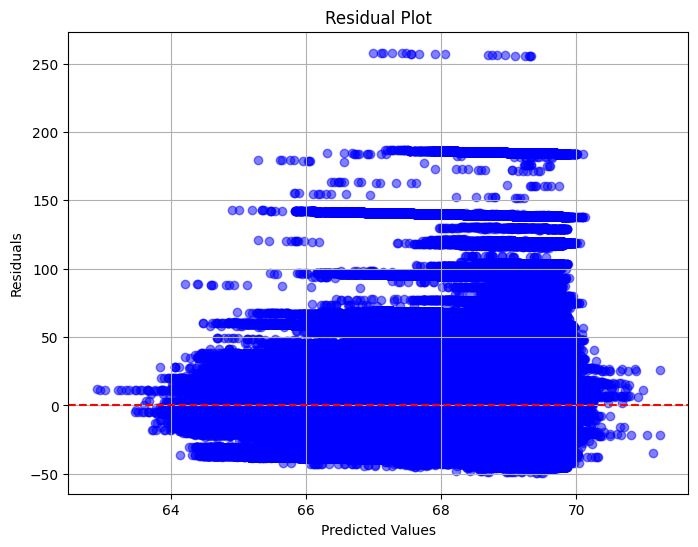

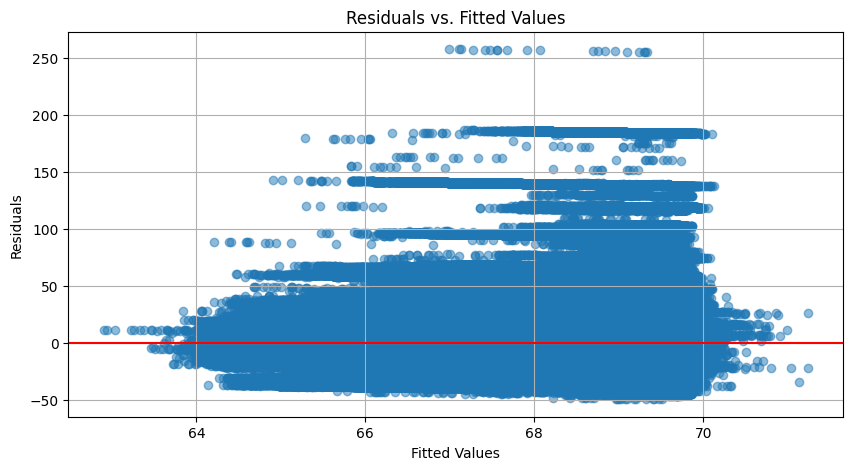

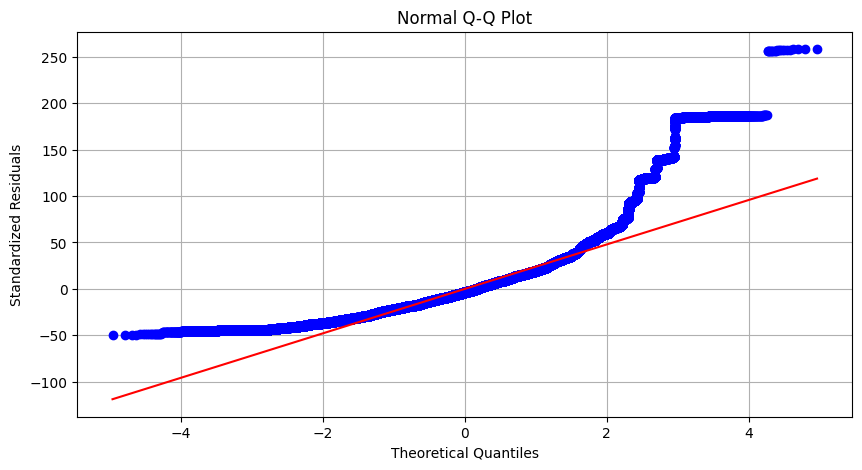


###Tests(Training)
Shapiro-Wilk Test:
Test Statistic: 0.8911657097294772
p-value: 2.9831295361684327e-167
Null hypothesis (residuals are normally distributed) rejected.

Anderson-Darling Test:
Test Statistic: 115232.41523918882
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Null hypothesis (residuals are normally distributed) rejected.

Cramer Von Mises Test:
Test Statistic: 688847.1112638229
p-value: 0
Null hypothesis (residuals are normally distributed) rejected.

Kolmogorov-Smirnov Test:
Test Statistic: 0.5683840425234405
p-value: 0.0
Null hypothesis (residuals are normally distributed) rejected.

Shapiro Francia Test:
Test Statistic: 0.8911657097294772
p-value: 2.9831295361684327e-167
Null hypothesis (residuals are normally distributed) rejected.

###Tests(Testing)
Shapiro-Wilk Test:
Test Statistic: 0.8907824479615821
p-value: 4.475720814840251e-164
Null hypothesis (residuals are normally distributed) rejected.

Anderson-Darling Test:
Test Statistic: 28850.640759967966
Critical 

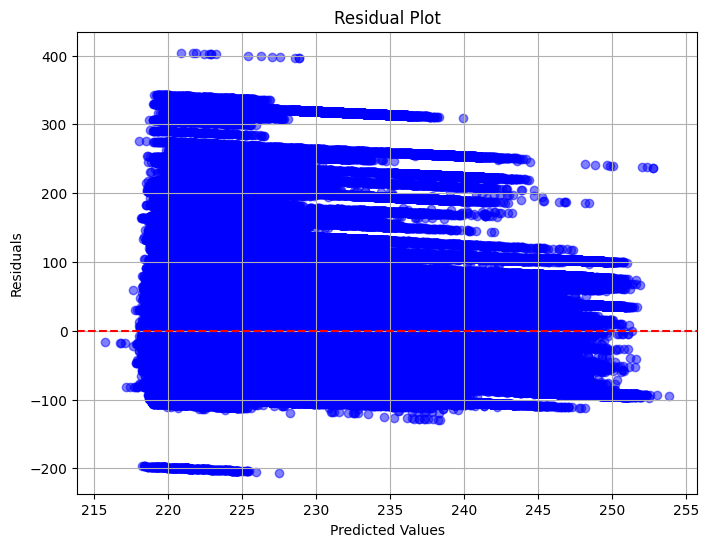

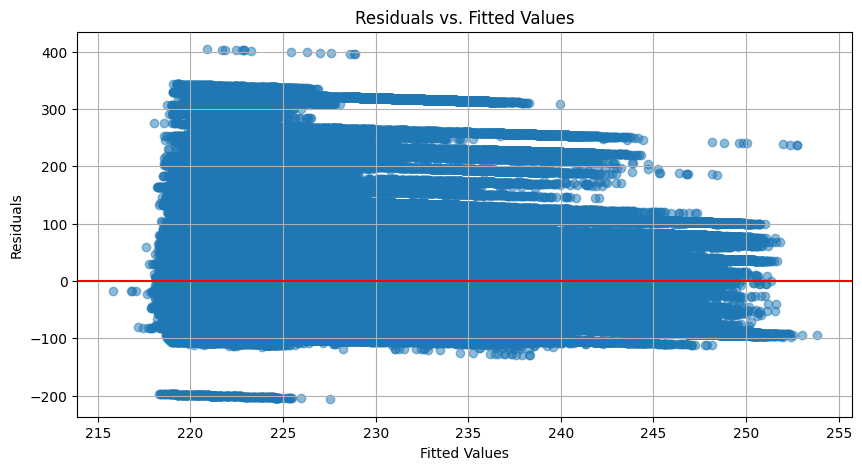

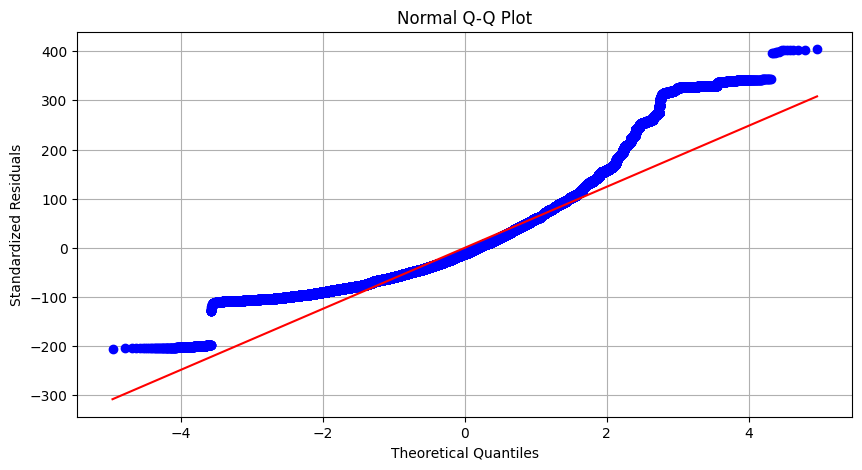


###Tests(Training)
Shapiro-Wilk Test:
Test Statistic: 0.9242851852525668
p-value: 2.585989095935729e-155
Null hypothesis (residuals are normally distributed) rejected.

Anderson-Darling Test:
Test Statistic: 115806.1023507379
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Null hypothesis (residuals are normally distributed) rejected.

Cramer Von Mises Test:
Test Statistic: 690297.130199979
p-value: 0
Null hypothesis (residuals are normally distributed) rejected.

Kolmogorov-Smirnov Test:
Test Statistic: 0.5697248164712907
p-value: 0.0
Null hypothesis (residuals are normally distributed) rejected.

Shapiro Francia Test:
Test Statistic: 0.9242851852525668
p-value: 2.585989095935729e-155
Null hypothesis (residuals are normally distributed) rejected.

###Tests(Testing)
Shapiro-Wilk Test:
Test Statistic: 0.9247840329421394
p-value: 8.906431098669274e-152
Null hypothesis (residuals are normally distributed) rejected.

Anderson-Darling Test:
Test Statistic: 28597.74763288861
Critical Value

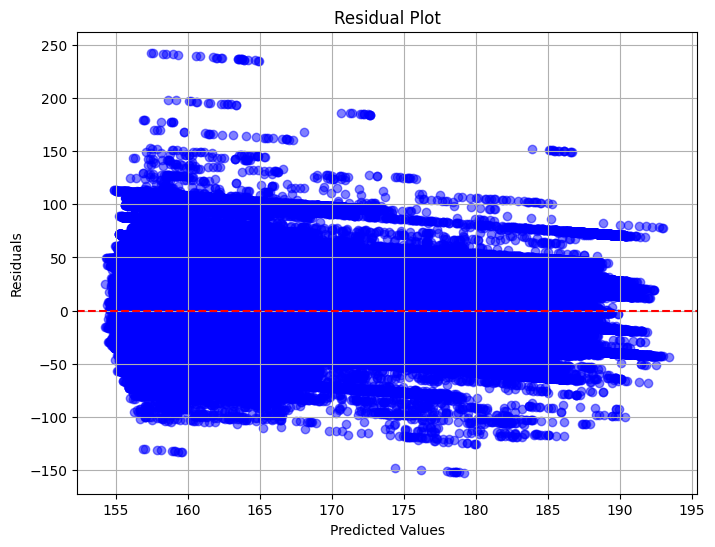

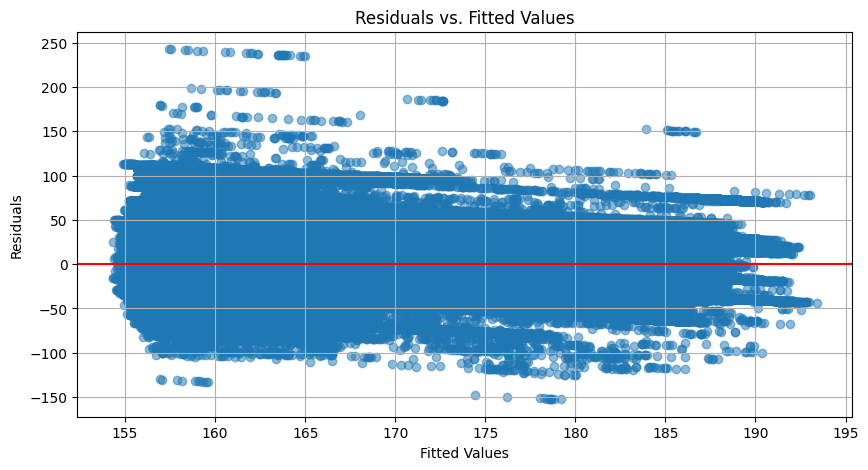

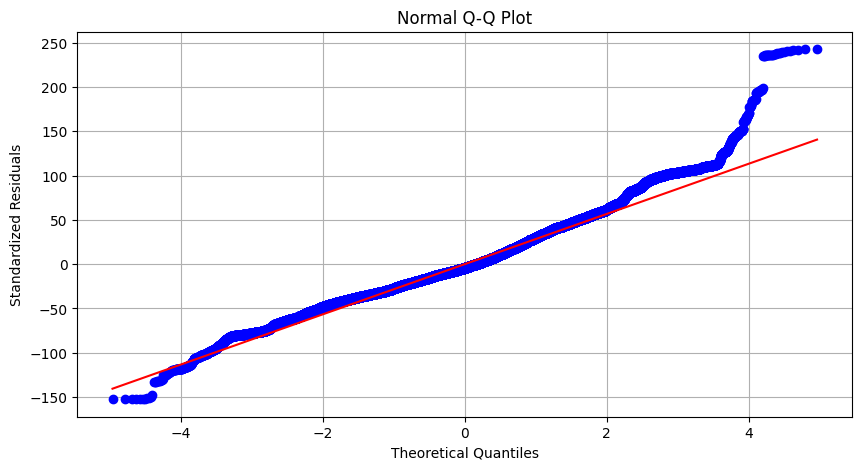


###Tests(Training)
Shapiro-Wilk Test:
Test Statistic: 0.9794002429365755
p-value: 3.623005221185215e-116
Null hypothesis (residuals are normally distributed) rejected.

Anderson-Darling Test:
Test Statistic: 50973.42061833106
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Null hypothesis (residuals are normally distributed) rejected.

Cramer Von Mises Test:
Test Statistic: 683615.6697602201
p-value: 0
Null hypothesis (residuals are normally distributed) rejected.

Kolmogorov-Smirnov Test:
Test Statistic: 0.5633502617182407
p-value: 0.0
Null hypothesis (residuals are normally distributed) rejected.

Shapiro Francia Test:
Test Statistic: 0.9794002429365755
p-value: 3.623005221185215e-116
Null hypothesis (residuals are normally distributed) rejected.

###Tests(Testing)
Shapiro-Wilk Test:
Test Statistic: 0.9803443297901004
p-value: 1.5522677995127026e-111
Null hypothesis (residuals are normally distributed) rejected.

Anderson-Darling Test:
Test Statistic: 11886.252072330797
Critical Va

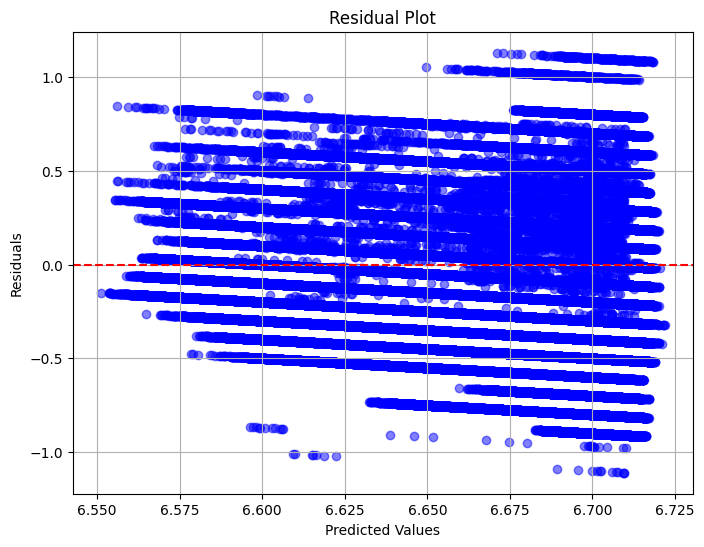

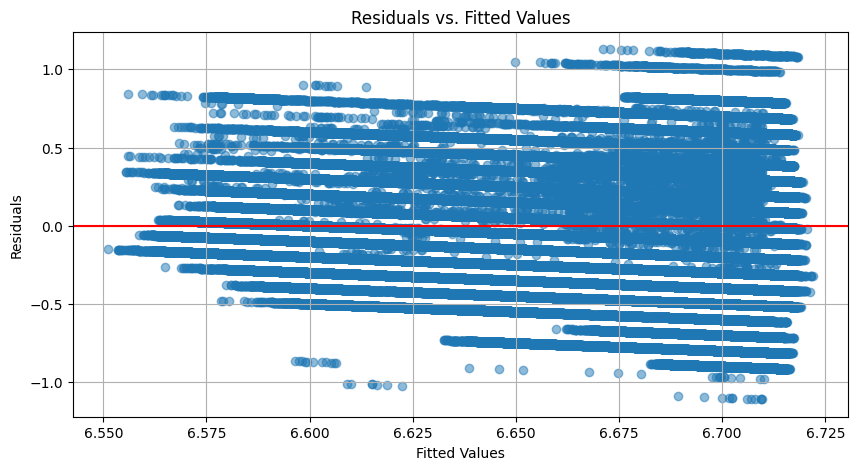

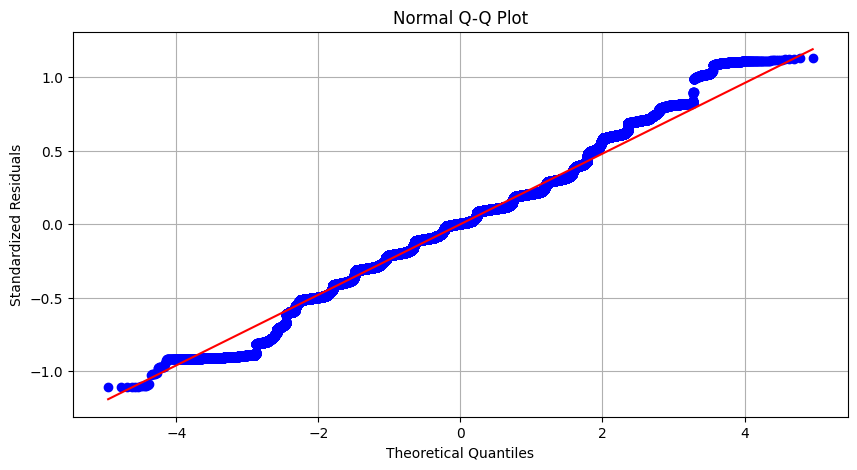


###Tests(Training)
Shapiro-Wilk Test:
Test Statistic: 0.9854753585665906
p-value: 1.2249822499925704e-106
Null hypothesis (residuals are normally distributed) rejected.

Anderson-Darling Test:
Test Statistic: 35160.06615289394
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Null hypothesis (residuals are normally distributed) rejected.

Cramer Von Mises Test:
Test Statistic: 666283.0929698212
p-value: 0
Null hypothesis (residuals are normally distributed) rejected.

Kolmogorov-Smirnov Test:
Test Statistic: 0.5436602623223209
p-value: 0.0
Null hypothesis (residuals are normally distributed) rejected.

Shapiro Francia Test:
Test Statistic: 0.9854753585665906
p-value: 1.2249822499925704e-106
Null hypothesis (residuals are normally distributed) rejected.

###Tests(Testing)
Shapiro-Wilk Test:
Test Statistic: 0.9869422278300648
p-value: 1.6112074484660416e-100
Null hypothesis (residuals are normally distributed) rejected.

Anderson-Darling Test:
Test Statistic: 7477.266013243934
Critical V

In [46]:
for i in classes:
    linear_reg(i)